Carlos Garcia - 21000475

### Librerias

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

### Datos

In [2]:
trainset = pd.read_excel('./input/estaturas.xlsx', sheet_name = 'normales', names = ['Estatura', 'Edad']) 
data = pd.read_excel('./input/estaturas.xlsx', sheet_name = 'valtest(normales)', names = ['Estatura', 'Edad'])
anomalies = pd.read_excel('./input/estaturas.xlsx', sheet_name = 'valtest(anomalias)', names = ['Estatura', 'Edad'])

In [3]:
print(trainset.shape)
print(data.shape)
print(anomalies.shape)

(46, 2)
(8, 2)
(4, 2)


In [4]:
data['label'] = 0
anomalies['label'] = 1

In [5]:
data = np.array_split(data.values, 2)
anomalies = np.array_split(anomalies.values, 2)

cvdata = np.vstack((data[0], anomalies[0]))
testset = np.vstack((data[1], anomalies[1]))

print(testset.shape)
print(cvdata.shape)

(6, 3)
(6, 3)


In [6]:
trainset.head()

,Estatura,Edad
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


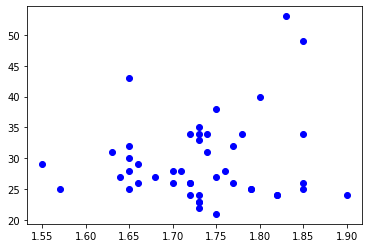

In [7]:
plt.scatter(x = trainset['Estatura'], y = trainset['Edad'], c = 'blue')
plt.show()

### Algoritmo

In [8]:
def estimateDistribParams(x):
    mean = np.mean(x, axis = 0)
    covmatrix = np.cov(x.T)
    return mean, covmatrix

In [9]:
def getProbability(x, mean, sigma):
    p = multivariate_normal(mean = mean, cov = sigma)
    probs = p.pdf(x)
    return probs

In [10]:
def anomalyDetection(probs, y, epsilon):
    yhat = np.piecewise(probs, [probs < epsilon, probs >= epsilon], [1, 0])
    f1_score = np.round(metrics.f1_score(y, yhat), 4)
    
    return yhat, f1_score

In [11]:
def selectTreshold(x, y, mean, sigma):
    probs = getProbability(x, mean, sigma)
    steps = (max(probs) - min(probs)) / 1000
    epsilon_grid = np.arange(min(probs), max(probs), steps)
    
    f1_scores = [anomalyDetection(probs, y, e)[1] for e in epsilon_grid]
    idx = np.argmax(f1_scores)
    
    print("Optimal treshold selected = {}".format(epsilon_grid[idx]))
    print("F1 Score obtained = {}".format(f1_scores[idx]))
    
    return epsilon_grid[idx], f1_scores[idx]

### Tunning CrossValidation

In [12]:
mean, sdev = estimateDistribParams(trainset.values)

In [13]:
epsilon, score = selectTreshold(cvdata[:, :-1], cvdata[:, -1], mean, sdev)

Optimal treshold selected = 0.00018691176319452995
F1 Score obtained = 1.0


### Evaluación

In [15]:
preds, score = anomalyDetection(getProbability(testset[:, :-1], mean, sdev), testset[:, -1], epsilon)
print("F1 Score obtained = {}".format(score))

F1 Score obtained = 1.0


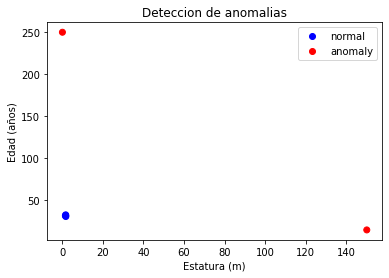

In [16]:
scatter = plt.scatter(x = testset[:, 0], y = testset[:, 1], c = preds, cmap = ListedColormap(['b','r']))
plt.legend(handles = scatter.legend_elements()[0], labels = ['normal', 'anomaly'])
plt.title('Deteccion de anomalias')
plt.xlabel('Estatura (m)')
plt.ylabel('Edad (años)')
plt.show()